In [1]:
import cv2
import numpy as np
import tensorflow as tf
import os
import random
from skimage import io
from skimage import filters
from datetime import datetime

In [12]:
appliance = ['AirConditioner', 'ILB', 'Fan', 'Fridge', 'Hairdryer', 'Heater', 'CFL', 'Laptop', 'Microwave', 'Vacuum', 'Washer']
classifier_data = random.sample(appliance, 11)
classifier_data.sort()
print(classifier_data)

['AirConditioner', 'CFL', 'Fan', 'Fridge', 'Hairdryer', 'Heater', 'ILB', 'Laptop', 'Microwave', 'Vacuum', 'Washer']


In [13]:
def load_image(path):
    img_list = []
    for rootdir, filedir, filenames in os.walk(path):
        for filename in filenames:
            img = io.imread(path + filename)
            img_flat = np.reshape(img, (1,-1))
            img_list.append(img_flat)
    return img_list

In [27]:
data = []
labels = []
for i in enumerate(classifier_data):
    path = "D:\\AnacondaWorkspace\\PLAID数据处理\\conv2d\\32x32\\%s\\"%i[1]
    request_data = load_image(path)
    print(i)
    data.extend(np.array(request_data, dtype=np.float32))
    for j in range(len(request_data)):
        label = np.zeros(len(classifier_data))
        label[i[0]] = 1
        labels.append(label)

data_list = np.array(data, dtype=np.float32)
data_flat = np.reshape(data_list, (-1, 2500))
labels_list = np.array(labels, dtype=np.float32)

(0, 'AirConditioner')
(1, 'CFL')
(2, 'Fan')
(3, 'Fridge')
(4, 'Hairdryer')
(5, 'Heater')
(6, 'ILB')
(7, 'Laptop')
(8, 'Microwave')
(9, 'Vacuum')
(10, 'Washer')


In [28]:
data_flat.shape

(1074, 2500)

In [29]:
labels_list.shape

(1074, 11)

In [30]:
from sklearn.model_selection import train_test_split
Train_data, Test_data, train_labels,test_labels = train_test_split(
    data_flat, labels_list, test_size = 0.3, random_state = 42
)

In [31]:
Test_data.shape

(323, 2500)

In [32]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)
def bias_variable(shape):
    initial = tf.constant(0.0, shape=shape)
    return tf.Variable(initial)
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [33]:
len(classifier_data)

11

In [34]:
def train():
    xs = tf.placeholder(tf.float32, [None, 50*50*1], name='input')
    ys = tf.placeholder(tf.float32, [None, len(classifier_data)], name='label')
    keep_prob = tf.placeholder(tf.float32)
    x_image = tf.reshape(xs, [-1, 50, 50, 1])
    #conv1 
    W_conv1 = weight_variable([5,5,1,50])
    b_conv1 = bias_variable([50])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    #conv2
    W_conv2 = weight_variable([5,5,50,50])
    b_conv2 = bias_variable([50])
    h_conv2 = tf.nn.leaky_relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    #conv3
#     W_conv3 = weight_variable([3,3,16,32])
#     b_conv3 = bias_variable([32])
#     h_conv3 = tf.nn.leaky_relu(conv2d(h_pool1, W_conv2) + b_conv2)
# #     h_pool2 = max_pool_2x2(h_conv2) 
    
    
    nodes=np.int(h_pool2.shape[1]*h_pool2.shape[2]*h_pool2.shape[3])
    
#         #  fc1 layer
    W_fc1 = weight_variable([nodes, 2500])
    b_fc1 = bias_variable([2500])
    h_pool2_flat = tf.reshape(h_pool2, [-1, nodes])
#     h_pool2_flat = tf.reshape(h_conv1, [-1, nodes])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob=1.)
    
    #  fc2 layer
    W_fc2 = weight_variable([2500, len(classifier_data)])
    b_fc2 = bias_variable([len(classifier_data)])
    
    prediction = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2, name='softmax')
    label = tf.argmax(prediction, 1, name='output')
    

    corrrect_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(ys, 1))
    accuracy = tf.reduce_mean(tf.cast(corrrect_prediction, tf.float32))
    
    #loss
    cross_entropy = tf.reduce_mean(
        -tf.reduce_sum(ys * tf.log(prediction), 1)
    )
    
    learning_rate = 0.0001
    train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)
  
    saver = tf.train.Saver(max_to_keep=3)
    
    do_train = 1
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    round_num = 64
    train_epoch = 1001
    start = datetime.now()
    result = []
    labels = []
    if do_train == 1:
        for epoch in range(train_epoch):
            batch_xs = []
            batch_ys = []
            for i in range(round_num):
                rand_num = random.randint(0, Train_data.shape[0] - 1)
                batch_xs.append(Train_data[rand_num])
                batch_ys.append(train_labels[rand_num])
            cost_train, _=sess.run([cross_entropy,train_step],feed_dict={xs:batch_xs, ys:batch_ys, keep_prob: 1.0})
            if epoch % 2 == 0:
                state = np.random.get_state()
                np.random.shuffle(Test_data)
                np.random.set_state(state)
                np.random.shuffle(test_labels)
                pred_train = sess.run(accuracy,feed_dict={xs: batch_xs, ys: batch_ys, keep_prob:1.0})
                
                cost_test, pred_test, pred = sess.run([cross_entropy, accuracy, label],feed_dict={xs: Test_data, ys: test_labels, keep_prob:1.0})
                labels.append(pred)
                result.append([(datetime.now() - start).total_seconds(), pred_test, cost_train, pred_train, cost_test])
                print("step",epoch ,"test acc is :",pred_test,"cost is :", cost_test)
#     if do_train == 0:
#         epoch = train_epoch - 1
#         saver.restore(sess, "save/nets/cnn_mnist_basic.ckpt" )
#         result = sess.run(prediction, feed_dict={xs:test_data, ys:test_label, keep_prob:1.})
#         print(result)
    return result, labels
tf.reset_default_graph()

In [ ]:
result_data, prediction = train()

step 0 test acc is : 0.43343654 cost is : 1.815661
step 2 test acc is : 0.7058824 cost is : 1.242919
step 4 test acc is : 0.5975232 cost is : 1.1251585
step 6 test acc is : 0.69349843 cost is : 0.8937388
step 8 test acc is : 0.7027864 cost is : 0.9110401
step 10 test acc is : 0.74613005 cost is : 0.7520398
step 12 test acc is : 0.7647059 cost is : 0.6710623
step 14 test acc is : 0.78328174 cost is : 0.6396083
step 16 test acc is : 0.7987616 cost is : 0.61170715
step 18 test acc is : 0.8111455 cost is : 0.5731477
step 20 test acc is : 0.8266254 cost is : 0.5264839
step 22 test acc is : 0.81733745 cost is : 0.5524136
step 24 test acc is : 0.8049536 cost is : 0.5714894
step 26 test acc is : 0.80804956 cost is : 0.5631213
step 28 test acc is : 0.8328173 cost is : 0.52754176
step 30 test acc is : 0.81424147 cost is : 0.526518
step 32 test acc is : 0.84210527 cost is : 0.49670517
step 34 test acc is : 0.8328173 cost is : 0.61708695
step 36 test acc is : 0.8111455 cost is : 0.6564657
step 38 

In [13]:
y = []
for i in range(len(test_labels)):
    y.append(np.argmax(test_labels[i],0))
y = np.array(y, dtype=np.int32)

In [14]:
prediction[-1]

array([ 8,  5,  8,  4,  2,  1,  2,  8,  4,  6, 10,  1,  6,  8,  4,  4,  6,
        9,  8,  7,  4,  7,  2,  7,  0,  1,  6,  2,  1,  2,  7,  7,  9,  6,
        9,  2,  7,  2,  2,  7,  2,  8,  2,  2,  2,  4,  6,  6,  2,  0,  7,
        8,  6,  4,  7,  8,  2,  2,  4,  7,  0,  8,  4,  1,  2,  7,  9,  2,
        3,  0,  7,  6,  9,  2,  1,  2,  1,  7,  8,  6,  1,  1,  7,  1,  0,
        1,  0,  2,  8,  8,  6,  9,  4,  7,  1,  1,  8,  1,  8,  4,  4,  3,
        5,  1,  0,  4,  8,  6,  1,  8,  8,  7,  6,  1,  4,  0,  4,  4,  2,
        7,  8,  2,  7,  2,  0,  5,  0,  4,  4,  8,  8,  4,  7,  8,  4,  2,
        4,  7,  4,  2,  2,  2,  2,  6,  8,  7,  9,  8,  1,  7,  6,  2,  7,
        3,  6,  4,  7,  1,  6,  1,  8,  7,  5,  1,  7,  2,  9,  0,  7,  5,
        1,  8,  2,  7,  4,  4,  8,  1,  3, 10,  7,  4,  4,  7,  4,  6,  3,
        1,  0,  1,  2,  6,  4,  1,  4,  7,  4,  8,  4,  4,  5,  7,  7,  7,
        8,  7,  7,  5,  8,  0,  4,  1,  1,  6,  4,  1,  5,  3,  1,  2,  2,
        1,  1,  2,  0,  7

In [15]:
y

array([ 8,  5,  8,  4,  2,  1,  2,  8,  4,  6, 10,  1,  6,  8,  4,  4,  6,
        9,  8,  7,  4,  7,  2,  7,  0,  1,  3,  2,  1,  2,  7,  4,  9,  6,
        9,  0,  7,  2,  2,  0,  2,  8,  2,  2,  4,  4,  6,  6,  2,  0,  7,
        8,  6,  4,  7,  8,  2,  2,  4,  7,  0,  8,  4,  1,  2,  7,  9,  2,
        3,  5,  7,  6,  9,  2,  1,  2,  1,  7,  8,  6,  1,  1,  7,  1,  0,
        1,  0,  2,  8,  8,  6,  9,  4,  7,  1,  1,  8,  1,  8,  4,  4,  3,
        5,  1,  3,  4,  8,  6,  1,  8,  8,  7,  6,  1,  4,  0,  4,  4,  0,
        7,  8,  2,  7,  2,  0,  5,  0,  4,  4,  8,  8,  4,  7,  8,  4,  2,
        4,  7,  4,  2,  2,  2,  2,  6,  8,  7,  9,  8,  1,  7,  6,  2,  7,
        3,  3,  4,  7,  1,  6,  1,  8,  1,  4,  1,  7,  2,  9,  0,  7,  5,
        1,  8,  2,  7,  4,  4,  8,  1,  0, 10,  7,  4,  4,  7,  4,  6,  3,
        1,  0,  1,  2,  6,  4,  1,  4,  7,  4,  8,  4,  4,  5,  7,  7,  7,
        8,  7,  7,  5,  8,  3,  4,  1,  1,  6,  4,  1,  4,  6,  1,  2,  2,
        1,  1,  2,  2,  7

In [16]:
from sklearn.metrics import classification_report
y_true = y
y_pred = prediction[-1]
target_name = classifier_data
print(classification_report(y_true, y_pred, target_names=appliance))

                precision    recall  f1-score   support

AirConditioner       0.68      0.71      0.70        21
           ILB       1.00      0.91      0.95        46
           Fan       0.94      0.94      0.94        48
        Fridge       0.60      0.60      0.60        10
     Hairdryer       1.00      0.90      0.95        50
        Heater       0.85      0.92      0.88        12
           CFL       0.91      0.97      0.94        32
        Laptop       0.89      1.00      0.94        47
     Microwave       1.00      1.00      1.00        38
        Vacuum       1.00      1.00      1.00        12
        Washer       1.00      0.86      0.92         7

      accuracy                           0.92       323
     macro avg       0.90      0.89      0.89       323
  weighted avg       0.93      0.92      0.92       323



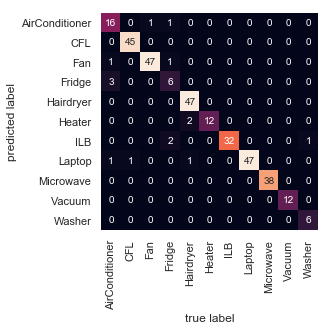

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix
%matplotlib inline

mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_name,
            yticklabels=target_name)
plt.xlabel('true label')
plt.ylabel('predicted label');

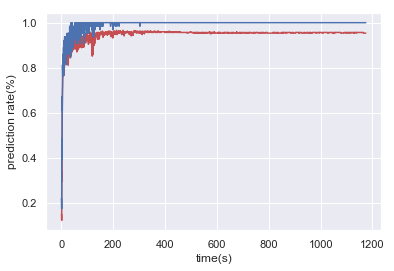

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

x_data_test = [v[0] for v in result_data]
y_data_test = [v[1] for v in result_data]

x_data_train = [v[0] for v in result_data]
y_data_train = [v[3] for v in result_data]
plt.xlabel('time(s)')
plt.ylabel('prediction rate(%)')
plt.plot(x_data_test, y_data_test, '-', c='r')
plt.plot(x_data_train, y_data_train, '-', c='b')